# Mars Entry-Descent-Landing Mission Scenario

This case study demonstrates using Pacti for formalizing a simplified version of a Mars Entry-Descent-Landing mission scenario based on the following paper: [R. Prakash et al. 2008](#ref1)
and the Mars 2020 EDL timeline from https://mars.nasa.gov/mars2020/timeline/landing/entry-descent-landing/

![](https://mars.nasa.gov/internal_resources/961/)

The figure above shows significant waypoints across the timeline of the EDL phase, a complex orchestration of multiple subsystems including the backshell, parachute, powered descent and sky crane. To coordinate the design of these subsystems, it is necessary to break down the overall EDL objective -- decelerate from 20,000 kilometers per hour down to zero -- into segments and allocate each segment to a subsystem. Verifying that an allocation is feasible typically requires exploring subsystem design trades and finding combinations of trades across subsystems that meet the overall allocation. The design process is highly iterative where the allocation changes as experts learn more about the capabilities and limitations of the subsystem design alternatives.

For this case study, we have segmented the overall Mars 2020 EDL timeline into 4 segments -- S1, S2, S3, and S4 -- as shown below:

![](figures/m2020-edl-timeline-segmented.png)

EDL engineers at JPL characterize these segments in terms of entry and exit conditions, some of which are included in the diagram above, others in the narrative explanations at https://mars.nasa.gov/mars2020/timeline/landing/entry-descent-landing/.

In [1]:
# The following Python imports provide access to the Pacti API 
# and to the plotting libraries for visualizing algebraic contracts.

%matplotlib widget

from pacti.iocontract import *
from pacti.terms.polyhedra import *
import matplotlib.pyplot as plt

from edl import *

# Segment S1: parachute Entry

For explanations, see: https://mars.nasa.gov/resources/25445/perseverance-rover-decelerating-in-the-martian-atmosphere-illustration/

![](https://mars.nasa.gov/system/resources/detail_files/25445_04_PeakHeating-1200.jpg)

For the contract below, it would be tempting to add an output variable, `t1`, with a guarantee: `t1 = t0 + dt0`. 

In [2]:
# EDL begins when the spacecraft reaches the top of the Martian atmosphere, travelling nearly 20,000 kilometers per hour (kph).
print(f"atmospheric_v_entry = {atmospheric_v_entry}")

# The heat shield slows the spacecraft to under 1,600 kph.
# This point marks be the exit of the atmospheric entry segment
# and the entry of the parachute deployment segment.
print(f"atmospheric_v_exit = {atmospheric_v_exit}")

print(f"atmospheric_t_entry = {atmospheric_t_entry}")
print(f"atmospheric_t_exit = {atmospheric_t_exit}")

atmospheric_t_duration = atmospheric_t_exit - atmospheric_t_entry
atmospheric_t_duration_min = atmospheric_t_duration*0.96
atmospheric_t_duration_max = atmospheric_t_duration*1.03

atmospheric_deacceleration = abs((atmospheric_v_entry - atmospheric_v_exit) / (atmospheric_t_entry - atmospheric_t_exit))
print(f"atmospheric_deacceleration={atmospheric_deacceleration}")

atmospheric_min_deacceleration = atmospheric_deacceleration*0.94
print(f"atmospheric_min_deacceleration={atmospheric_min_deacceleration}")

atmospheric_max_deacceleration = atmospheric_deacceleration*1.03
print(f"atmospheric_max_deacceleration={atmospheric_max_deacceleration}")

S1 = PolyhedralContract.from_string(
    input_vars=[
      "dt0",          # time duration for the atmospheric segment from entry to exit.
      "v0"            # velocity @ entry
    ],
    output_vars=[
      "v1"            # velocity @ exit
    ],
    assumptions=[
      # velocity @ entry
      f"v0 = {atmospheric_v_entry}"
    ],
    guarantees=[
      # validity bounds on minimum exit velocity
      # 1000 <= v1
      "-v1 <= -1000",
      
      # atmospheric_min_deacceleration * dt0 <= v0 - v1 <= atmospheric_max_deacceleration * dt0
      # v0 - v1 <= atmospheric_max_deacceleration * dt0
      f" v0 - v1 - {atmospheric_max_deacceleration} dt0 <= 0",

      # atmospheric_min_deacceleration * dt0 <= v0 - v1
      f"-v0 + v1 + {atmospheric_min_deacceleration} dt0 <= 0"
    ])

print(S1)

atmospheric_v_entry = 20000.0
atmospheric_v_exit = 1600.0
atmospheric_t_entry = 0.0
atmospheric_t_exit = 90.0
atmospheric_deacceleration=204.44444444444446
atmospheric_min_deacceleration=192.17777777777778
atmospheric_max_deacceleration=210.57777777777778
InVars: [dt0, v0]
OutVars:[v1]
A: [
  v0 = 20000.0
]
G: [
  -v1 <= -1000.0
  -210.57777777777778 dt0 + v0 - v1 <= 0.0
  192.17777777777778 dt0 - v0 + v1 <= 0.0
]


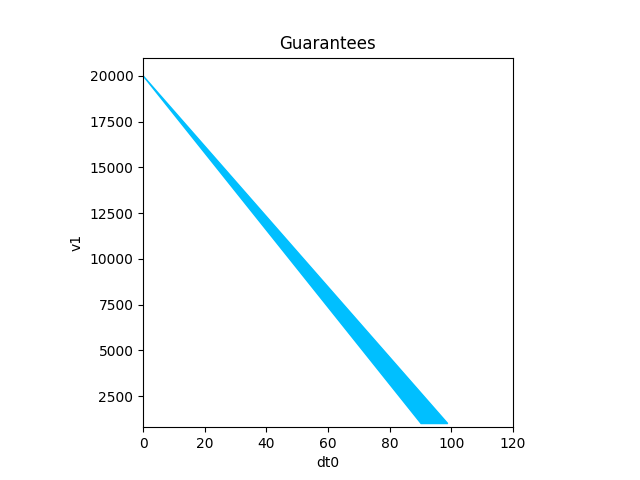

In [3]:
_ = plot_guarantees(
    contract=S1,
    x_var=Var("dt0"),
    y_var=Var("v1"),
    var_values={
        Var("v0"):atmospheric_v_entry
    },
    x_lims=(0, 120),
    y_lims=(800, 21000)
)

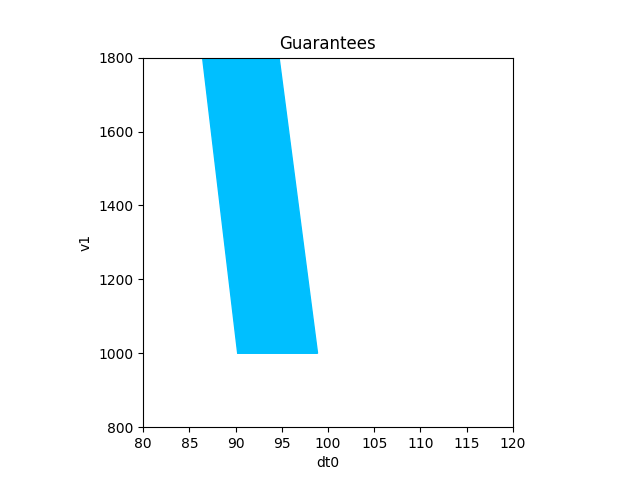

In [4]:
_ = plot_guarantees(
    contract=S1,
    x_var=Var("dt0"),
    y_var=Var("v1"),
    var_values={
        Var("v0"):atmospheric_v_entry
    },
    x_lims=(80, 120),
    y_lims=(800, 1800)
)

# Segment S2: Parachute Deployment

In [5]:
# The parachute can be safely deployed when the velocity is less than 1,600 kph.
parachute_v_entry = 1600.0

# The parachute maximum deceleration capability is 320 kph.
parachute_v_exit = 320.0

parachute_t_entry = 90.0
parachute_t_exit = 350.0
parachute_t_duration = parachute_t_exit - parachute_t_entry
parachute_t_duration_min = parachute_t_duration*0.96
parachute_t_duration_max = parachute_t_duration*1.03

parachute_deacceleration = abs((parachute_v_entry - parachute_v_exit) / (parachute_t_entry - parachute_t_exit))
print(f"parachute_deacceleration={parachute_deacceleration}")

parachute_min_deacceleration = parachute_deacceleration*0.94
print(f"parachute_min_deacceleration={parachute_min_deacceleration}")

parachute_max_deacceleration = parachute_deacceleration*1.03
print(f"parachute_max_deacceleration={parachute_max_deacceleration}")


S2 = PolyhedralContract.from_string(
    input_vars=[
      "dt1",          # time duration for the parachute deployment segment from entry to exit.
      "v1"            # entry velocity
    ],
    output_vars=[
      "v2"            # exit velocity
    ],
    assumptions=[
      # velocity @ entry
      f"v1 <= {parachute_v_entry}"
    ],
    guarantees=[
      # # parachute effectiveness is limited to v2 >= 320
      f"-v2 <= -{parachute_v_exit}",
      
      # parachute_min_deacceleration * dt1 <= v1 - v2 <= parachute_max_deacceleration * dt1
      # v1 - v2 <= parachute_max_deacceleration * dt1
      f" v1 - v2 - {parachute_max_deacceleration} dt1 <= 0",

      # parachutec_min_deacceleration * dt1 <= v1 - v2
      f"-v1 + v2 + {parachute_min_deacceleration} dt1 <= 0"
   ])

print(S2)

parachute_deacceleration=4.923076923076923
parachute_min_deacceleration=4.627692307692308
parachute_max_deacceleration=5.070769230769232
InVars: [dt1, v1]
OutVars:[v2]
A: [
  v1 <= 1600.0
]
G: [
  -v2 <= -320.0
  -5.070769230769232 dt1 + v1 - v2 <= 0.0
  4.627692307692308 dt1 - v1 + v2 <= 0.0
]


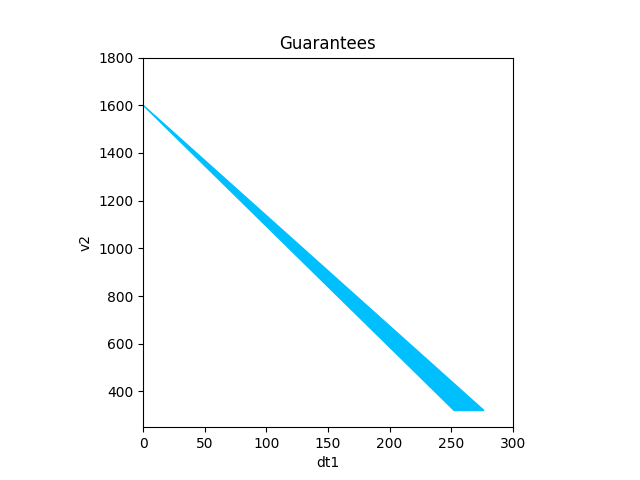

In [6]:
_ = plot_guarantees(
    contract=S2,
    x_var=Var("dt1"),
    y_var=Var("v2"),
    var_values={
        Var("v1"):parachute_v_entry
    },
    x_lims=(0, 300),
    y_lims=(250, 1800)
)

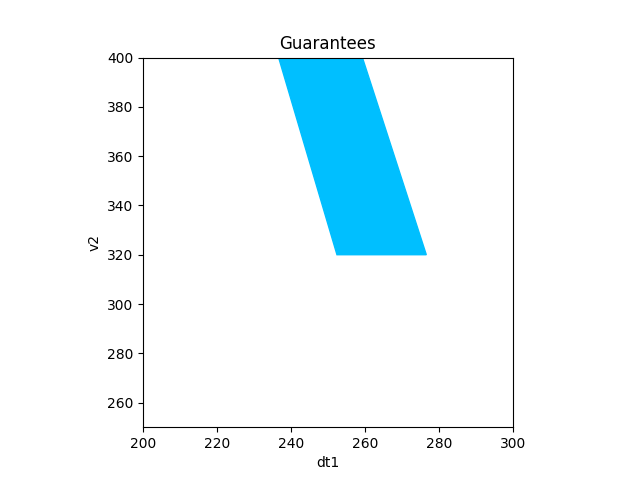

In [7]:
_ = plot_guarantees(
    contract=S2,
    x_var=Var("dt1"),
    y_var=Var("v2"),
    var_values={
        Var("v1"):parachute_v_entry
    },
    x_lims=(200, 300),
    y_lims=(250, 400)
)

# Compose S1 and S2


In [8]:
S12 = S1.compose(S2)

print(S12)

InVars: [dt0, v0, dt1]
OutVars:[v2]
A: [
  -192.177777777778 dt0 + v0 <= 1600.0
  v0 = 20000.0
]
G: [
  -5.07076923076923 dt1 - v2 <= -1000.0
  -v2 <= -320.0
  192.177777777778 dt0 + 4.627692307692308 dt1 - v0 + v2 <= 0.0
]


Plotting the guarantees for the nominal entry conditions (i.e., `t0=atmospheric_t_entry, v0=atmospheric_v_entry`) requires using a value of `dt0` that is compatible with the constraints. In the example below, we use `dt0=98`.

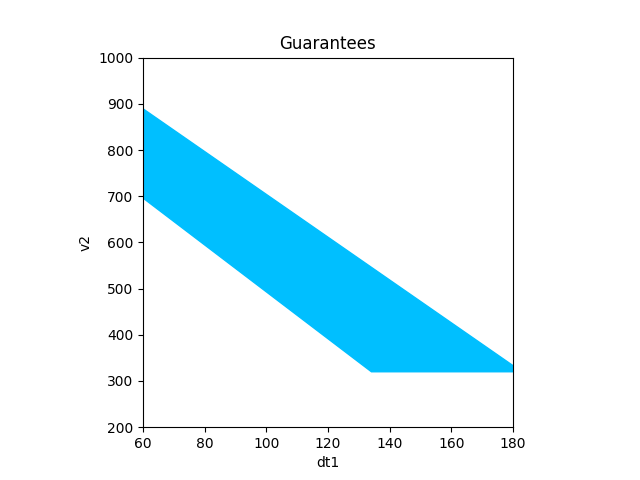

In [9]:
_ = plot_guarantees(
    contract=S12,
    x_var=Var("dt1"),
    y_var=Var("v2"),
    var_values={
        Var("v0"):atmospheric_v_entry,
        Var("dt0"):98
    },
    x_lims=(60, 180),
    y_lims=(200, 1000)
)

# Segment S3: Powered Descent

![](https://mars.nasa.gov/system/resources/detail_files/25449_08_PoweredDescent-1200.jpg)

In [10]:
powered_descent_v_entry = 600.0
powered_descent_v_exit = 2.7

powered_descent_t_entry = 350.0
powered_descent_t_exit = 398.0
powered_descent_t_duration =powered_descent_t_exit - powered_descent_t_entry
powered_descent_t_duration_min = powered_descent_t_duration*0.96
powered_descent_t_duration_max = powered_descent_t_duration*1.03

powered_descent_deacceleration = abs((powered_descent_v_entry - powered_descent_v_exit) / (powered_descent_t_entry - powered_descent_t_exit))
print(f"powered_descent_deacceleration={powered_descent_deacceleration}")

powered_descent_min_deacceleration = powered_descent_deacceleration*0.94
print(f"powered_descent_min_deacceleration={powered_descent_min_deacceleration}")

powered_descent_max_deacceleration = powered_descent_deacceleration*1.03
print(f"powered_descent_max_deacceleration={powered_descent_max_deacceleration}")

S3 = PolyhedralContract.from_string(
    input_vars=[
      "dt2",          # time duration for the powered descent from entry to exit.
      "v2"            # entry velocity
    ],
    output_vars=[
      "v3"            # exit velocity
    ],
    assumptions=[
      # velocity @ entry
      f"v2 <= {powered_descent_v_entry}",
    ],
    guarantees=[
      # velocity @ exit
      "-v3 <= 0",
      
      # powered_descent_min_deacceleration * dt2 <= v2 - v3 <= powered_descent_max_deacceleration * dt1
      # v2 - v3 <= powered_descent_max_deacceleration * dt2
      f" v2 - v3 - {powered_descent_max_deacceleration} dt2 <= 0",

      # powered_descent_min_deacceleration * dt2 <= v2 - v3
      f"-v2 + v3 + {powered_descent_min_deacceleration} dt2 <= 0"
    ])

print(S3)

powered_descent_deacceleration=12.44375
powered_descent_min_deacceleration=11.697125
powered_descent_max_deacceleration=12.8170625
InVars: [dt2, v2]
OutVars:[v3]
A: [
  v2 <= 600.0
]
G: [
  -v3 <= 0.0
  -12.8170625 dt2 + v2 - v3 <= 0.0
  11.697125 dt2 - v2 + v3 <= 0.0
]


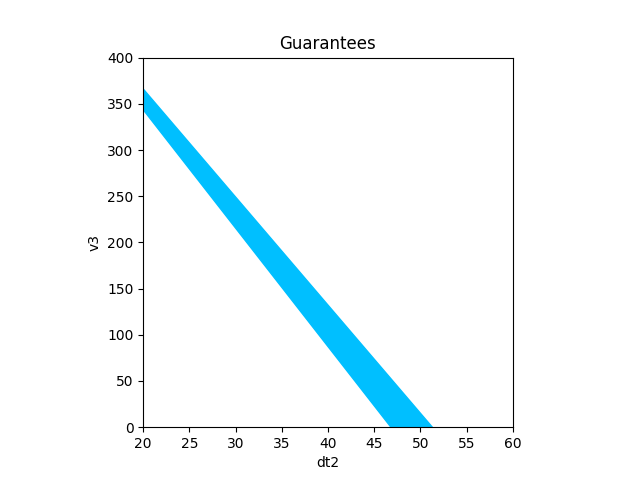

In [11]:
_ = plot_guarantees(
    contract=S3,
    x_var=Var("dt2"),
    y_var=Var("v3"),
    var_values={
        Var("v2"):powered_descent_v_entry
    },
    x_lims=(20, 60),
    y_lims=(0, 400)
)

# Compose S1 and S2 and S3

In [12]:
S123 = S12.compose(S3)
print(S123)

InVars: [dt0, v0, dt1, dt2]
OutVars:[v3]
A: [
  -192.177777777778 dt0 - 4.62769230769231 dt1 + v0 <= 600.0
  -192.177777777778 dt0 + v0 <= 1600.0
  v0 = 20000.0
]
G: [
  -5.07076923076923 dt1 - 12.8170625 dt2 - v3 <= -1000.0
  -12.8170625 dt2 - v3 <= -320.0
  -v3 <= 0.0
  192.177777777778 dt0 + 4.62769230769231 dt1 + 11.697125 dt2 - v0 + v3 <= 0.0
]


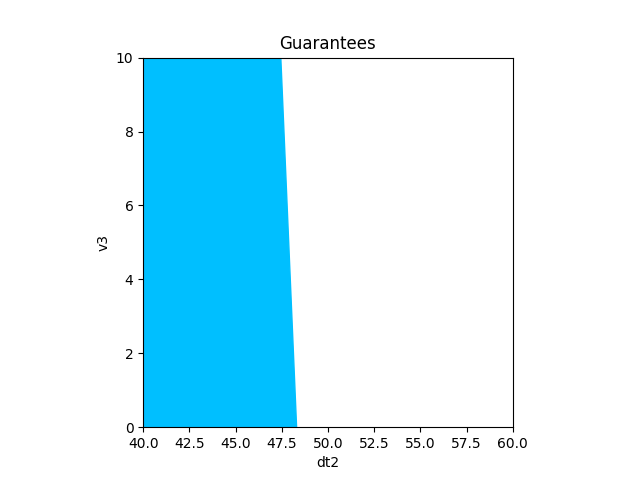

In [13]:
_ = plot_guarantees(
    contract=S123,
    x_var=Var("dt2"),
    y_var=Var("v3"),
    var_values={
        Var("v0"):atmospheric_v_entry,
        Var("dt0"):98,
        Var("dt1"):130,
    },
    x_lims=(40, 60),
    y_lims=(0, 10)
)

# Segment S4: Sky Crane

![](https://mars.nasa.gov/system/resources/detail_files/3650_PIA14839-full2.jpg)

In [14]:
# The sky crane maneuver initiates at a velocity less than 2.7 kph.
print(f"skycrane_v_entry = {skycrane_v_entry}")

# The sky crane maneuver ends when the rover velocity reaches 0 kph.
print(f"skycrane_v_exit = {skycrane_v_exit}")

print(f"skycrane_t_entry = {skycrane_t_entry}")
print(f"skycrane_t_exit = {skycrane_t_exit}")

skycrane_t_duration = skycrane_t_exit - skycrane_t_entry
skycrane_t_duration_min = skycrane_t_duration*0.96
skycrane_t_duration_max = skycrane_t_duration*1.03

skycrane_deacceleration = abs((skycrane_v_entry - skycrane_v_exit) / (skycrane_t_entry - skycrane_t_exit))
print(f"skycrane_deacceleration={skycrane_deacceleration}")

skycrane_min_deacceleration = skycrane_deacceleration*0.94
print(f"skycrane_min_deacceleration={skycrane_min_deacceleration}")

skycrane_max_deacceleration = skycrane_deacceleration*1.03
print(f"skycrane_max_deacceleration={skycrane_max_deacceleration}")

S4 = PolyhedralContract.from_string(
    input_vars=[
      "dt3",          # time duration for the powered descent from entry to exit.
      "v3"            # entry velocity
    ],
    output_vars=[
      "v4"            # exit velocity
    ],
    assumptions=[
      # velocity @ entry
      f"v3 <= {skycrane_v_entry}"
    ],
    guarantees=[
      # velocity @ exit
      "-v4 <= 0",

      # skycrane_min_deacceleration * dt3 <= v3 - v4 <= skycrane_max_deacceleration * dt1
      # v3 - v4 <= skycrane_max_deacceleration * dt3
      f" v3 - v4 - {skycrane_max_deacceleration} dt3 <= 0",

      # skycrane_min_deacceleration * dt3 <= v3 - v4
      f"-v3 + v4 + {skycrane_min_deacceleration} dt3 <= 0"
    ])

print(S4)

skycrane_v_entry = 2.7
skycrane_v_exit = 0
skycrane_t_entry = 398.0
skycrane_t_exit = 410.0
skycrane_deacceleration=0.225
skycrane_min_deacceleration=0.2115
skycrane_max_deacceleration=0.23175
InVars: [dt3, v3]
OutVars:[v4]
A: [
  v3 <= 2.7
]
G: [
  -v4 <= 0.0
  -0.23175 dt3 + v3 - v4 <= 0.0
  0.2115 dt3 - v3 + v4 <= 0.0
]


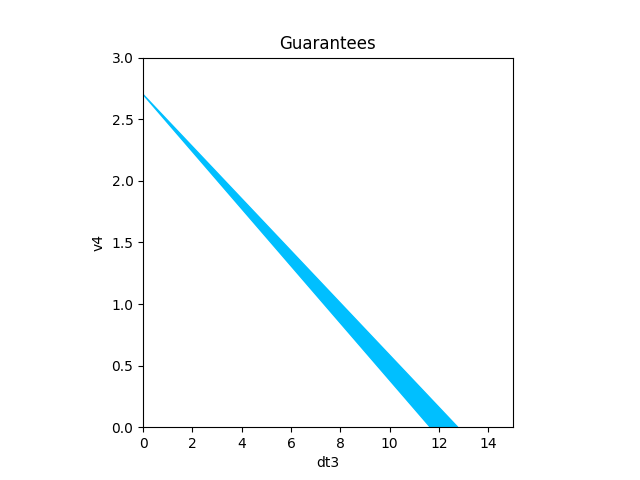

In [15]:
_ = plot_guarantees(
    contract=S4,
    x_var=Var("dt3"),
    y_var=Var("v4"),
    var_values={
        Var("v3"):skycrane_v_entry
    },
    x_lims=(0, 15),
    y_lims=(0, 3)
)

# Compose all EDL phase segment contracts (S1, S2, S3, S4)

In [16]:
S1234 = S123.compose(S4)
print(S1234)

InVars: [dt0, v0, dt1, dt2, dt3]
OutVars:[v4]
A: [
  -192.177777777778 dt0 - 4.62769230769231 dt1 - 11.697125 dt2 + v0 <= 2.7
  -192.177777777778 dt0 - 4.62769230769231 dt1 + v0 <= 600.0
  -192.177777777778 dt0 + v0 <= 1600.0
  v0 = 20000.0
]
G: [
  -5.07076923076923 dt1 - 12.8170625 dt2 - 0.23175 dt3 - v4 <= -1000.0
  -12.8170625 dt2 - 0.23175 dt3 - v4 <= -320.0
  192.177777777778 dt0 + 4.62769230769231 dt1 + 11.697125 dt2 + 0.2115 dt3 - v0 + v4 <= 0.0
  -v4 <= 0.0
]


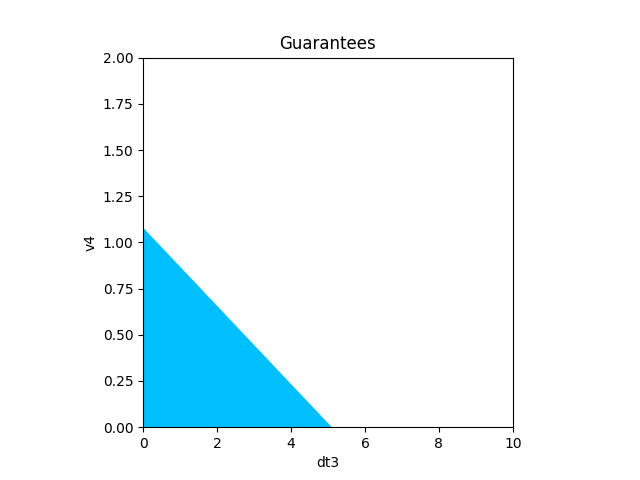

In [17]:
_ = plot_guarantees(
    contract=S1234,
    x_var=Var("dt3"),
    y_var=Var("v4"),
    var_values={
        Var("v0"):atmospheric_v_entry,
        Var("dt0"):98,
        Var("dt1"):128,
        Var("dt2"):49
    },
    x_lims=(0, 10),
    y_lims=(0, 2)
)

# Using contract algebra for manipulating contracts

Pacti provides 3 algebraic operations on contracts:
- composition as shown above
- quotient, which computes a kind of difference operation
- refinement, which verifies that a detailed contract conforms with an abstract contract.

Here, we want to demonstrates two applications of the quotient operation for calculating a missing contract and for characterizing the gap between contracts that cannot be composed.
Before we go into these details, we need to write a specification for the toplevel EDL phase itself, which is very simple: 
- assume the entry conditions are as given
- guarantee the desired exit conditions are as given.

In [18]:
EDL0 = PolyhedralContract.from_string(
    input_vars=[
      "t0",          # time @ entry
      "v0"           # velocity @ entry
    ],
    output_vars=[
      "t4",
      "v4"            # velocity @ exit
    ],
    assumptions=[
      # time @ entry
      f"t0 = {atmospheric_t_entry}",

      # velocity @ entry
      f"v0 = {atmospheric_v_entry}",
    ],
    guarantees=[
      # bound for time @ exit
      "t4 <= 500",
      "-t4 <= 0",

      # bound for velocity @ exit
      "v4 <= 2.7",
      f"-v4 <= {skycrane_v_exit}"
    ])
print(EDL0)

InVars: [t0, v0]
OutVars:[t4, v4]
A: [
  t0 = 0.0
  v0 = 20000.0
]
G: [
  t4 <= 500.0
  -t4 <= 0.0
  v4 <= 2.7
  -v4 <= 0.0
]


In [19]:
DTconstraints = EDL0.quotient(S1234)
print(DTconstraints)

InVars: [t0]
OutVars:[t4, dt0, dt1, dt2, dt3]
A: [
  t0 = 0.0
]
G: [
  t4 <= 500.0
  -t4 <= 0.0
  -192.177777777778 dt0 - 4.62769230769231 dt1 - 11.697125 dt2 - 0.2115 dt3 <= -19997.3
  -192.177777777778 dt0 - 4.62769230769231 dt1 - 11.697125 dt2 <= -19997.3
  -192.177777777778 dt0 - 4.62769230769231 dt1 <= -19400.0
  -192.177777777778 dt0 <= -18400.0
]


In [20]:
EDL1 = PolyhedralContract.from_string(
    input_vars=[
      "t0",          # time @ entry
      "dt0",         # duration of S1
      "dt1",         # duration of S2
      "dt2",         # duration of S3
      "dt3",         # duration of S4
      "v0"           # velocity @ entry
    ],
    output_vars=[
      "v4"            # velocity @ exit
    ],
    assumptions=[
      # time @ entry
      f"t0 = {atmospheric_t_entry}",

      # velocity @ entry
      f"v0 = {atmospheric_v_entry}",

      "-dt0 <= 100",
      "-dt0 <= -96",
      "dt1 <= 130",
      "-dt1 <= -126",
      "dt2 <= 52",
      "-dt2 <= -47",
      "dt3 <= 5.1",
      "-dt3 <= -4.9",
    ],
    guarantees=[
      # velocity @ exit
      "v4 <= 2.7",
      f"-v4 <= {skycrane_v_exit}"
    ])
print(EDL1)

InVars: [t0, dt0, dt1, dt2, dt3, v0]
OutVars:[v4]
A: [
  t0 = 0.0
  v0 = 20000.0
  -dt0 <= 100.0
  -dt0 <= -96.0
  dt1 <= 130.0
  -dt1 <= -126.0
  dt2 <= 52.0
  -dt2 <= -47.0
  dt3 <= 5.1
  -dt3 <= -4.9
]
G: [
  v4 <= 2.7
  -v4 <= 0.0
]


## Calculating missing contracts using quotient

In the EDL scenario described above, suppose we have contracts for a subset of the EDL segments, e.g.: `S1`, `S2`, and `S4`. Can we characterize the missing contract for `S3`?

In [21]:
# First, compose the contracts we have: S1, S2, and S4.
S124 = S12.compose(S4)
print(S124)

InVars: [dt0, v0, dt1, dt3, v3]
OutVars:[v2, v4]
A: [
  -192.177777777778 dt0 + v0 <= 1600.0
  v0 = 20000.0
  v3 <= 2.7
]
G: [
  -5.07076923076923 dt1 - v2 <= -1000.0
  -v2 <= -320.0
  192.177777777778 dt0 + 4.627692307692308 dt1 - v0 + v2 <= 0.0
  -v4 <= 0.0
  -0.23175 dt3 + v3 - v4 <= 0.0
  0.2115 dt3 - v3 + v4 <= 0.0
]


In [22]:
# Next, define the missing S3 as the quotient of toplevel contract w.r.t. what we have.
missingS3 = EDL1.quotient(S124)
print(missingS3)

InVars: [t0, dt2, v2]
OutVars:[v3]
A: [
  t0 = 0.0
  dt2 <= 52.0
  -dt2 <= -47.0
]
G: [
  v3 <= 2.7
]


In [23]:
S123_implied = S12.compose(missingS3)
print(S123_implied)

InVars: [dt0, v0, dt1, t0, dt2]
OutVars:[v3]
A: [
  t0 = 0.0
  dt2 <= 52.0
  -dt2 <= -47.0
  -192.177777777778 dt0 + v0 <= 1600.0
  v0 = 20000.0
]
G: [
  192.177777777778 dt0 - 0.44307692307691937 dt1 - v0 <= -1000.0
  192.177777777778 dt0 + 4.62769230769231 dt1 - v0 <= -320.0
  v3 <= 2.7
]


In [24]:
S1234_implied = S123_implied.compose(S4)
print(S1234_implied)

InVars: [dt0, v0, dt1, t0, dt2, dt3]
OutVars:[v4]
A: [
  t0 = 0.0
  dt2 <= 52.0
  -dt2 <= -47.0
  -192.177777777778 dt0 + v0 <= 1600.0
  v0 = 20000.0
]
G: [
  192.177777777778 dt0 - 0.44307692307691937 dt1 - v0 <= -1000.0
  192.177777777778 dt0 + 4.62769230769231 dt1 - v0 <= -320.0
  0.2115 dt3 + v4 <= 2.7
  -v4 <= 0.0
  -0.020250000000000018 dt3 <= 0.0
]


In [25]:
print(S1234_implied.refines(EDL1))

True


## Characterizing a composition mismatch as a quotient gap

In [40]:
EDL1_left_right = PolyhedralContract.from_string(
    input_vars=[
      "t0",          # time @ entry
      "dt0",         # duration of S1
      "dt1_right",   # duration of S2
      "dt2",         # duration of S3
      "dt3",         # duration of S4
      "v0"           # velocity @ entry
    ],
    output_vars=[
      "v4"            # velocity @ exit
    ],
    assumptions=[
      # time @ entry
      f"t0 = {atmospheric_t_entry}",

      # velocity @ entry
      f"v0 = {atmospheric_v_entry}",

      "-dt0 <= 100",
      "-dt0 <= -96",
      "dt1_right <= 130",
      "-dt1_right <= -126",
      "dt2 <= 52",
      "-dt2 <= -47",
      "dt3 <= 5.1",
      "-dt3 <= -4.9",
    ],
    guarantees=[
      # velocity @ exit
      "v4 <= 2.7",
      f"-v4 <= {skycrane_v_exit}"
    ])
print(EDL1_left_right)

InVars: [t0, dt0, dt1_right, dt2, dt3, v0]
OutVars:[v4]
A: [
  t0 = 0.0
  v0 = 20000.0
  -dt0 <= 100.0
  -dt0 <= -96.0
  dt1_right <= 130.0
  -dt1_right <= -126.0
  dt2 <= 52.0
  -dt2 <= -47.0
  dt3 <= 5.1
  -dt3 <= -4.9
]
G: [
  v4 <= 2.7
  -v4 <= 0.0
]


In [41]:
S1_left = PolyhedralContract.from_string(
    input_vars=[
      "dt0",          # time duration for the atmospheric segment from entry to exit.
      "v0"            # velocity @ entry
    ],
    output_vars=[
      "v1_left"          # velocity @ exit
    ],
    assumptions=[
      # velocity @ entry
      f"v0 = {atmospheric_v_entry}"
    ],
    guarantees=[
      # validity bounds on minimum exit velocity
      # 1000 <= v1
      "-v1_left <= -1000",
      
      # atmospheric_min_deacceleration * dt0 <= v0 - v1_left <= atmospheric_max_deacceleration * dt0
      # v0 - v1_p <= atmospheric_max_deacceleration * dt0
      f" v0 - v1_left - {atmospheric_max_deacceleration} dt0 <= 0",

      # atmospheric_min_deacceleration * dt0 <= v0 - v1_left
      f"-v0 + v1_left + {atmospheric_min_deacceleration} dt0 <= 0"
    ])

print(S1_left)

InVars: [dt0, v0]
OutVars:[v1_left]
A: [
  v0 = 20000.0
]
G: [
  -v1_left <= -1000.0
  -210.57777777777778 dt0 + v0 - v1_left <= 0.0
  192.17777777777778 dt0 - v0 + v1_left <= 0.0
]


In [42]:
EDL1_left = EDL1_left_right.quotient(S1_left)
print(EDL1_left)

InVars: [t0, dt1_right, dt2, dt3, v1_left]
OutVars:[v4]
A: [
  t0 = 0.0
  dt1_right <= 130.0
  -dt1_right <= -126.0
  dt2 <= 52.0
  -dt2 <= -47.0
  dt3 <= 5.1
  -dt3 <= -4.9
  -v1_left <= -1000.0
  v1_left <= 1550.9333333333343
]
G: [
  v4 <= 2.7
  -v4 <= 0.0
]


In [43]:
S234 = S2.compose(S3).compose(S4)
print(S234)

InVars: [dt1, v1, dt2, dt3]
OutVars:[v4]
A: [
  -4.62769230769231 dt1 - 11.697125 dt2 + v1 <= 2.7
  -4.62769230769231 dt1 + v1 <= 600.0
  v1 <= 1600.0
]
G: [
  -12.8170625 dt2 - 0.23175 dt3 - v4 <= -320.0
  -5.070769230769232 dt1 - 12.8170625 dt2 - 0.23175 dt3 + v1 - v4 <= 0.0
  4.627692307692308 dt1 + 11.697125 dt2 + 0.2115 dt3 - v1 + v4 <= 0.0
  -v4 <= 0.0
]


In [45]:
S234_right = PolyhedralContract.from_string(
    input_vars=[ "dt1_right", "v1_right", "dt2", "dt3"],
    output_vars=["v4"],
    assumptions=[
      "-4.62769230769231 dt1_right - 11.697125 dt2 + v1_right <= 2.7",
      "-4.62769230769231 dt1_right + v1_right <= 600.0",
      "v1_right <= 1600.0"
    ],
    guarantees=[
      "-12.8170625 dt2 - 0.23175 dt3 - v4 <= -320.0",
      "-5.070769230769232 dt1_right - 12.8170625 dt2 - 0.23175 dt3 + v1_right - v4 <= 0.0",
      "4.627692307692308 dt1_right + 11.697125 dt2 + 0.2115 dt3 - v1_right + v4 <= 0.0",
      "-v4 <= 0.0"
    ])
print(S234_right)

InVars: [dt1_right, v1_right, dt2, dt3]
OutVars:[v4]
A: [
  -4.62769230769231 dt1_right - 11.697125 dt2 + v1_right <= 2.7
  -4.62769230769231 dt1_right + v1_right <= 600.0
  v1_right <= 1600.0
]
G: [
  -12.8170625 dt2 - 0.23175 dt3 - v4 <= -320.0
  -5.070769230769232 dt1_right - 12.8170625 dt2 - 0.23175 dt3 + v1_right - v4 <= 0.0
  4.627692307692308 dt1_right + 11.697125 dt2 + 0.2115 dt3 - v1_right + v4 <= 0.0
  -v4 <= 0.0
]


In [46]:
EDL1_right = EDL1_left_right.quotient(S234_right)
print(EDL1_right)

ValueError: The guarantees contain the following variables which are neitherinputs nor outputs: [<Var v4>]. Inputs: [<Var t0>, <Var dt0>, <Var v0>]. Outputs: [<Var v1_right>]. Guarantees: [
  v4 <= 2.7
  v1_right <= 1135.5541057692312
]

In [47]:
WithGap = S1_left.compose(S234_right)
print(WithGap)

InVars: [dt0, v0, dt1_right, v1_right, dt2, dt3]
OutVars:[v1_left, v4]
A: [
  v0 = 20000.0
  -4.62769230769231 dt1_right - 11.697125 dt2 + v1_right <= 2.7
  -4.62769230769231 dt1_right + v1_right <= 600.0
  v1_right <= 1600.0
]
G: [
  -v1_left <= -1000.0
  -210.57777777777778 dt0 + v0 - v1_left <= 0.0
  192.17777777777778 dt0 - v0 + v1_left <= 0.0
  -12.8170625 dt2 - 0.23175 dt3 - v4 <= -320.0
  -5.070769230769232 dt1_right - 12.8170625 dt2 - 0.23175 dt3 + v1_right - v4 <= 0.0
  4.627692307692308 dt1_right + 11.697125 dt2 + 0.2115 dt3 - v1_right + v4 <= 0.0
  -v4 <= 0.0
]


In [48]:
MissingGap = EDL1_left_right.quotient(WithGap)
print(MissingGap)

ValueError: The guarantees contain the following variables which are neitherinputs nor outputs: [<Var v4>]. Inputs: [<Var t0>, <Var v1_left>]. Outputs: [<Var v1_right>]. Guarantees: [
  v4 <= 2.7
  v1_right <= 1135.5541057692312
]

## References

<a id="ref1"></a> __[R. Prakash et al. 2008](https://ieeexplore.ieee.org/abstract/document/4526283)__

R. Prakash et al., "Mars Science Laboratory Entry, Descent, and Landing System Overview," 2008 IEEE Aerospace Conference, Big Sky, MT, USA, 2008, pp. 1-18, doi: 10.1109/AERO.2008.4526283.
